In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm


#from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession

In [ ]:
try:
    sc = SparkContext(appName="SDDM")
    #, master='spark://fs.dslc.liacs.nl:7078')
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
    print('warn')


In [ ]:
# INIT
CATALOGUE_FILE = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/catalogue_v5.4.csv"
HEADER_FILE = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_writable/catalogue_v5.3_header.csv"
OVERLAP_FILE = "../2.Overlap/overlap_mosaics.csv"
WRITE_TO = "./artifact_detection.csv"

INTENSITY_THRESHOLD = 0.8
RADIUS_THRESHOLD = 200 # arcseconds
ECCENTRICITY_THRESHOLD = 3

type_dict = {'label': str}
header = open(HEADER_FILE, 'r').readline()[:-1].split(',')
cat = pd.read_csv(CATALOGUE_FILE, sep=',', names=header).astype(type_dict)
cat = cat[(cat["overlap"] == 0) | (cat["overlap"] == 2)]
cat.drop(cat.tail(1).index,inplace=True)
print(len(cat))
cat.tail()

1861279


,label,total_pixels,x_pixels,y_pixels,integrated_intensity,brightest_pixel,brightest_pixel_x,brightest_pixel_y,brightest_pixel_RA,brightest_pixel_DEC,...,fit_y_axis,fit_theta,deconv_x,deconv_y,integrated_intensity_fit,ratio_residual,mosaic,object,mosaic_id,overlap
2287873.0,P198+57_11002,36,7,6,0.550844,0.000690567,4864,8679,198.213,59.1732,...,2.08132,2.56474,1.9143,2.83216,0.556048,0.0526855,P198+57,11002,209,2
2287874.0,P198+57_11003,39,8,6,0.522666,0.000566274,4090,8686,198.842,59.1766,...,1.70811,-0.122944,4.06405,0.422976,0.531733,0.0555658,P198+57,11003,209,2
2287875.0,P198+57_11004,20,7,4,0.204829,0.000356476,4832,8686,198.239,59.1762,...,1.20289,0.0320175,5.54893,0,0.209438,0.12552,P198+57,11004,209,0
2287876.0,P198+57_11005,30,7,6,0.32241,0.000377613,4759,8690,198.298,59.178,...,2.4241,2.335,0,4.07245,0.331345,0.105084,P198+57,11005,209,0
2287877.0,P198+57_11006,36,9,5,0.387224,0.000350652,4219,8692,198.737,59.1792,...,1.37658,0.0505499,10.6434,0,0.392656,0.107348,P198+57,11006,209,2


Make intensities histogram


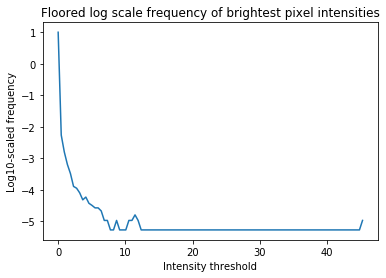

In [ ]:
# INTENSITY HISTOGRAM
disable = False
if not disable:
    print("Make intensities histogram")
    nbins = 100
    
    br_pixels = cat.loc[:, 'brightest_pixel']
    
    edges = np.histogram_bin_edges(br_pixels, bins=nbins)
    hist = np.histogram(br_pixels, bins=edges)[0].astype("float64")
    
    hist /= np.sum(hist) # normalise
    hist *= 10
    hist += np.min(hist[hist > 0]) # scale-up, avoid zeroes
    hist = np.log10(hist) # logarithm

    fig, ax = plt.subplots()
    ax.set_xlabel("Intensity threshold")
    ax.set_ylabel("Log10-scaled frequency")
    ax.set_title("Floored log scale frequency of brightest pixel intensities")
    ax.plot(edges[0:-1], hist)
    plt.show()



In [ ]:
# HIGH INTENSITY SOURCES
print("Find intense sources")

intense_sources = []

intense = np.full(len(cat.index), INTENSITY_THRESHOLD)
br_pixels = cat.loc[:, 'brightest_pixel']
br_indices = br_pixels >= intense
br_chunk = cat.iloc[np.where(br_indices == True)[0], :]
for ri, row in br_chunk.iterrows():
    intense_sources.append(row)
    
print("Intense sources:", len(intense_sources))

Find intense sources
Intense sources: 703


In [ ]:
intense_sources_dict = {} # convert to dictionary indexed by fits files
for src in intense_sources:
    fits = src["mosaic"]
    try:
        intense_sources_dict[fits].append(np.array([src['center_of_mass_RA'], src['center_of_mass_DEC']]))
    except KeyError:
        intense_sources_dict[fits] = [np.array([src['center_of_mass_RA'], src['center_of_mass_DEC']])]

for k, v in intense_sources_dict.items():
    print(k, v)
    break

P209+42 [array([208.11910636,  42.98993629]), array([210.134438  ,  43.06743551])]


In [ ]:
print("Generate overlap dict")
overlap_file = pd.read_csv(OVERLAP_FILE, sep=",", quotechar='"') # find overlap mosaics
overlap_dict = {} # make a better dictionary
for _, mosaic in overlap_file.iterrows():
    overlap_dict[mosaic["fitsfile"].split("_")[0]] = []

    overlaps = mosaic["overlaps"]
    overlaps = [overlaps, ""][pd.isna(overlaps)]
    overlaps += ";" + mosaic["fitsfile"]
    
    overlaps = overlaps.split(";")
    for i, ov in enumerate(overlaps):
        try:
            overlaps[i] = intense_sources_dict[ov.split("_")[0]]
        except KeyError:
            overlaps[i] = []
    for o in overlaps:
        for s in o:
            overlap_dict[mosaic["fitsfile"].split("_")[0]].append(s)

overlap_dict['P209+42']

Generate overlap dict


[array([204.10999596,  41.5202199 ]),
 array([206.38794763,  42.83762067]),
 array([205.47256385,  43.5890377 ]),
 array([205.77471677,  43.72321379]),
 array([205.77470766,  43.72319738]),
 array([205.04169568,  44.08724656]),
 array([210.41095344,  47.25396156]),
 array([208.79800434,  48.3679536 ]),
 array([210.88402358,  48.60344786]),
 array([213.76976868,  41.93231088]),
 array([214.30820608,  42.40411327]),
 array([208.11910636,  42.98993629]),
 array([210.134438  ,  43.06743551])]

In [ ]:
cat["eccentricity"] = np.exp(np.abs(np.log(cat['fit_x_axis'].astype(float) / cat['fit_y_axis'].astype(float)  )))
cat.loc[:, ["fit_y_axis", "fit_x_axis", "eccentricity"]].head()

/home/s2494876/miniconda3/envs/sddm/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,fit_y_axis,fit_x_axis,eccentricity
32767.0,1.8422,1.66076,1.109253
32768.0,1.58732,1.96232,1.236246
32769.0,0.823768,5.07546,6.161274
32770.0,1.81114,1.98999,1.098748
32771.0,13,1.35521,9.592607


In [ ]:
passed = np.array(
    cat.loc[cat["eccentricity"] >= ECCENTRICITY_THRESHOLD, ["label", "center_of_mass_RA", "center_of_mass_DEC", "brightest_pixel"]]
)
passed[:5]

array([['P209+42_5436', 208.43346783645973, 42.486207413569936],
       ['P209+42_5438', 208.40986905045963, 42.48836625414744],
       ['P209+42_5442', 208.39898053179886, 42.48901033694112],
       ['P209+42_5445', 208.85445434349168, 42.493798311250686],
       ['P209+42_5446', 208.39702506832126, 42.49228752772428]],
      dtype=object)

In [1]:
RADIUS_THRESHOLD_DEGREES = RADIUS_THRESHOLD / 3600 # convert from arcseconds to deg

def findArtifacts(row, fits, compile_near_sources, intensity_threshold_reduction_factor=1):  
    # FIND ARTIFACTS
    if row[-1] >= (INTENSITY_THRESHOLD * intensity_threshold_reduction_factor): 
        return (fits, False) # the source is a strong source - can never be artifact

    distance = np.array([math.sqrt(i) for i in np.sum(np.power(row[0:-1] - compile_near_sources, 2), axis=1)])
    if np.any(distance <= RADIUS_THRESHOLD_DEGREES):
        return (fits, True)
    else:
        return (fits, False)

In [ ]:
artifacts = []
t = 0

with tqdm(total=len(passed)) as pbar:
    for idx in range(len(passed)):
        k, v = findArtifacts(passed[idx, 1:], passed[idx, 0], 
                             overlap_dict[passed[idx, 0].split('_')[0]])
        artifacts.append((k, v))
        t += v
        pbar.update(1)
        
artifacts = np.array(artifacts)
print(t/len(passed))

100%|██████████| 380268/380268 [00:39<00:00, 9712.41it/s] 

0.04798983874530594


In [ ]:
artifacts[artifacts[:,1] == 'True'][:10]

array([['P209+42_7047', 'True'],
       ['P209+42_7060', 'True'],
       ['P209+42_7067', 'True'],
       ['P209+42_7097', 'True'],
       ['P209+42_7109', 'True'],
       ['P209+42_7128', 'True'],
       ['P209+42_7141', 'True'],
       ['P209+42_7171', 'True'],
       ['P209+42_7220', 'True'],
       ['P209+42_7230', 'True']], dtype='<U17')

# Old

In [ ]:
# WRITE OUT
print("Writing...")
wfile = open(WRITE_TO, 'w')
wfile.write("label,is_artifact") # make csv
for ci, chunk in enumerate(pd.read_csv(CATALOGUE_FILE, compression='infer', header=0, sep=',', quotechar='"', chunksize=CHUNKSIZE, error_bad_lines=False)):
    for ri, row in chunk.iterrows():
        index = ci * CHUNKSIZE + ri
        wfile.write("\n" + str(row[header_dict['label']]) + "," + str(artifact_indexed_list[index]))
wfile.close()